In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, applications, optimizers, losses
import matplotlib.pyplot as plt
import os
import tarfile
import scipy.io as sio
import numpy as np
import random
import cv2

In [ ]:
def save_train_data(fnames, labels, bboxes):
    src_folder ='/tmp/car_ims'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    for i in range(num_samples):
        fname = fnames[i][8:]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)

        src_image = cv2.imread(src_path)
        height, width = src_image.shape[:2]

        # margins of 16 pixels (Crop image according to a given bounding box)
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)

        if i in train_indexes:
            dst_folder = '/tmp/car_ims/train/'
        else:
            dst_folder = '/tmp/car_ims/valid/'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)
        dst_image = src_image[y1:y2, x1:x2]
        cv2.imwrite(dst_path, dst_image)

### Download and Separate Data

We first need to download the data from a remote server and seperate the data into training and testing sets. Note that you only need to download the data once, if you have downloaded the data before do not run the code in this section.

In [ ]:
!wget --no-check-certificate \
  http://ai.stanford.edu/~jkrause/car196/car_ims.tgz \
  -O /tmp/car_ims.tgz

--2022-08-12 17:14:07--  http://ai.stanford.edu/~jkrause/car196/car_ims.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1956628579 (1.8G) [application/x-gzip]
Saving to: ‘/tmp/car_ims.tgz’

/tmp/car_ims.tgz    100%[===================>]   1.82G  15.1MB/s    in 2m 8s   

2022-08-12 17:16:16 (14.6 MB/s) - ‘/tmp/car_ims.tgz’ saved [1956628579/1956628579]



In [ ]:
!wget --no-check-certificate \
  http://ai.stanford.edu/~jkrause/car196/cars_annos.mat \
  -O /tmp/cars_annos.mat

--2022-08-12 17:17:59--  http://ai.stanford.edu/~jkrause/car196/cars_annos.mat
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394471 (385K) [text/plain]
Saving to: ‘/tmp/cars_annos.mat’

/tmp/cars_annos.mat 100%[===================>] 385.23K   263KB/s    in 1.5s    

2022-08-12 17:18:01 (263 KB/s) - ‘/tmp/cars_annos.mat’ saved [394471/394471]



In [ ]:
!wget --no-check-certificate \
  http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat \
  -O /tmp/cars_test_annos.mat

--2022-08-12 17:16:59--  http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185758 (181K) [text/plain]
Saving to: ‘/tmp/cars_test_annos.mat’

/tmp/cars_test_anno 100%[===================>] 181.40K   169KB/s    in 1.1s    

2022-08-12 17:17:00 (169 KB/s) - ‘/tmp/cars_test_annos.mat’ saved [185758/185758]



In [ ]:
!rm -rf /tmp/car_ims/train/
!rm -rf /tmp/car_ims/test/
!rm -rf /tmp/car_ims/valid/

Unzip the compressed data. (You do not need to understand how this works)

In [ ]:
local_tar = '/tmp/car_ims.tgz'
my_tar = tarfile.open(local_tar)
my_tar.extractall('/tmp')
my_tar.close()

In [ ]:
car_annotation= sio.loadmat('/tmp/cars_annos.mat')

annotations = car_annotation['annotations']
annotations = np.transpose(annotations)

fnames = []
class_ids = []
labels = []
bboxes  = []
for annotation in annotations:
  bbox_x1 = annotation[0][1][0][0]
  bbox_y1 = annotation[0][2][0][0]
  bbox_x2 = annotation[0][3][0][0]
  bbox_y2 = annotation[0][4][0][0]

  class_id = annotation[0][5][0][0]
  bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
  labels.append(f'{class_id:06}')

  file_name = annotation[0][0][0]
  class_ids.append(class_id)
  fnames.append(file_name)

labels_count = np.unique(class_ids).shape[0]
print(np.unique(class_ids))
print('The number of different cars is %d' % labels_count)

save_train_data(fnames, labels, bboxes)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The number of different cars is 196


### Create a data generator

In [ ]:
datagen = ImageDataGenerator(validation_split=.1)
train_iter = datagen.flow_from_directory('/tmp/car_ims/train/', class_mode='categorical', batch_size=32)
test_iter = datagen.flow_from_directory('/tmp/car_ims/valid/', class_mode='categorical', batch_size=32)

Found 12948 images belonging to 196 classes.
Found 3237 images belonging to 196 classes.


In [ ]:
base_model = ResNet50(
    weights='imagenet',
    input_shape=(256,256,3),
    include_top=False
)

94781440/94765736 [==============================] - 2s 0us/step


### Build Model

In [ ]:
# TODO
# BUild your model

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(196, activation='softmax'))
model.layers[0].trainable = False
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 196)               50372     
                                                                 
Total params: 24,228,420
Trainable params: 640,708
Non-trainable params: 23,587,712
______________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train_iter, workers=32, batch_size=128, epochs=10, validation_data=test_iter)

Epoch 1/10
405/405 [==============================] - 104s 219ms/step - loss: 4.1697 - accuracy: 0.0946 - val_loss: 3.1480 - val_accuracy: 0.2057
Epoch 2/10
405/405 [==============================] - 85s 206ms/step - loss: 2.5437 - accuracy: 0.3268 - val_loss: 2.4654 - val_accuracy: 0.3395
Epoch 3/10
405/405 [==============================] - 87s 208ms/step - loss: 1.8684 - accuracy: 0.4794 - val_loss: 2.1202 - val_accuracy: 0.4205
Epoch 4/10
405/405 [==============================] - 86s 209ms/step - loss: 1.4693 - accuracy: 0.5750 - val_loss: 1.8140 - val_accuracy: 0.4986
Epoch 5/10
405/405 [==============================] - 86s 207ms/step - loss: 1.1880 - accuracy: 0.6444 - val_loss: 1.7215 - val_accuracy: 0.5249
Epoch 6/10
405/405 [==============================] - 86s 209ms/step - loss: 0.9707 - accuracy: 0.7028 - val_loss: 1.7301 - val_accuracy: 0.5317
Epoch 7/10
405/405 [==============================] - 87s 208ms/step - loss: 0.8009 - accuracy: 0.7496 - val_loss: 1.5779 - val_a

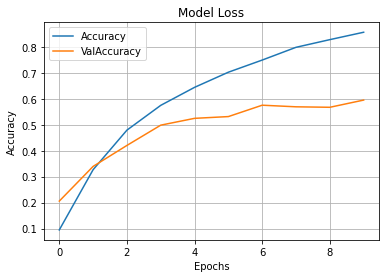

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "ValAccuracy"])
plt.title("Model Loss")
plt.grid()

In [ ]:
_NAMES = [
    'AM General Hummer SUV 2000',
    'Acura RL Sedan 2012',
    'Acura TL Sedan 2012',
    'Acura TL Type-S 2008',
    'Acura TSX Sedan 2012',
    'Acura Integra Type R 2001',
    'Acura ZDX Hatchback 2012',
    'Aston Martin V8 Vantage Convertible 2012',
    'Aston Martin V8 Vantage Coupe 2012',
    'Aston Martin Virage Convertible 2012',
    'Aston Martin Virage Coupe 2012',
    'Audi RS 4 Convertible 2008',
    'Audi A5 Coupe 2012',
    'Audi TTS Coupe 2012',
    'Audi R8 Coupe 2012',
    'Audi V8 Sedan 1994',
    'Audi 100 Sedan 1994',
    'Audi 100 Wagon 1994',
    'Audi TT Hatchback 2011',
    'Audi S6 Sedan 2011',
    'Audi S5 Convertible 2012',
    'Audi S5 Coupe 2012',
    'Audi S4 Sedan 2012',
    'Audi S4 Sedan 2007',
    'Audi TT RS Coupe 2012',
    'BMW ActiveHybrid 5 Sedan 2012',
    'BMW 1 Series Convertible 2012',
    'BMW 1 Series Coupe 2012',
    'BMW 3 Series Sedan 2012',
    'BMW 3 Series Wagon 2012',
    'BMW 6 Series Convertible 2007',
    'BMW X5 SUV 2007',
    'BMW X6 SUV 2012',
    'BMW M3 Coupe 2012',
    'BMW M5 Sedan 2010',
    'BMW M6 Convertible 2010',
    'BMW X3 SUV 2012',
    'BMW Z4 Convertible 2012',
    'Bentley Continental Supersports Conv. Convertible 2012',
    'Bentley Arnage Sedan 2009',
    'Bentley Mulsanne Sedan 2011',
    'Bentley Continental GT Coupe 2012',
    'Bentley Continental GT Coupe 2007',
    'Bentley Continental Flying Spur Sedan 2007',
    'Bugatti Veyron 16.4 Convertible 2009',
    'Bugatti Veyron 16.4 Coupe 2009',
    'Buick Regal GS 2012',
    'Buick Rainier SUV 2007',
    'Buick Verano Sedan 2012',
    'Buick Enclave SUV 2012',
    'Cadillac CTS-V Sedan 2012',
    'Cadillac SRX SUV 2012',
    'Cadillac Escalade EXT Crew Cab 2007',
    'Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
    'Chevrolet Corvette Convertible 2012',
    'Chevrolet Corvette ZR1 2012',
    'Chevrolet Corvette Ron Fellows Edition Z06 2007',
    'Chevrolet Traverse SUV 2012',
    'Chevrolet Camaro Convertible 2012',
    'Chevrolet HHR SS 2010',
    'Chevrolet Impala Sedan 2007',
    'Chevrolet Tahoe Hybrid SUV 2012',
    'Chevrolet Sonic Sedan 2012',
    'Chevrolet Express Cargo Van 2007',
    'Chevrolet Avalanche Crew Cab 2012',
    'Chevrolet Cobalt SS 2010',
    'Chevrolet Malibu Hybrid Sedan 2010',
    'Chevrolet TrailBlazer SS 2009',
    'Chevrolet Silverado 2500HD Regular Cab 2012',
    'Chevrolet Silverado 1500 Classic Extended Cab 2007',
    'Chevrolet Express Van 2007',
    'Chevrolet Monte Carlo Coupe 2007',
    'Chevrolet Malibu Sedan 2007',
    'Chevrolet Silverado 1500 Extended Cab 2012',
    'Chevrolet Silverado 1500 Regular Cab 2012',
    'Chrysler Aspen SUV 2009',
    'Chrysler Sebring Convertible 2010',
    'Chrysler Town and Country Minivan 2012',
    'Chrysler 300 SRT-8 2010',
    'Chrysler Crossfire Convertible 2008',
    'Chrysler PT Cruiser Convertible 2008',
    'Daewoo Nubira Wagon 2002',
    'Dodge Caliber Wagon 2012',
    'Dodge Caliber Wagon 2007',
    'Dodge Caravan Minivan 1997',
    'Dodge Ram Pickup 3500 Crew Cab 2010',
    'Dodge Ram Pickup 3500 Quad Cab 2009',
    'Dodge Sprinter Cargo Van 2009',
    'Dodge Journey SUV 2012',
    'Dodge Dakota Crew Cab 2010',
    'Dodge Dakota Club Cab 2007',
    'Dodge Magnum Wagon 2008',
    'Dodge Challenger SRT8 2011',
    'Dodge Durango SUV 2012',
    'Dodge Durango SUV 2007',
    'Dodge Charger Sedan 2012',
    'Dodge Charger SRT-8 2009',
    'Eagle Talon Hatchback 1998',
    'FIAT 500 Abarth 2012',
    'FIAT 500 Convertible 2012',
    'Ferrari FF Coupe 2012',
    'Ferrari California Convertible 2012',
    'Ferrari 458 Italia Convertible 2012',
    'Ferrari 458 Italia Coupe 2012',
    'Fisker Karma Sedan 2012',
    'Ford F-450 Super Duty Crew Cab 2012',
    'Ford Mustang Convertible 2007',
    'Ford Freestar Minivan 2007',
    'Ford Expedition EL SUV 2009',
    'Ford Edge SUV 2012',
    'Ford Ranger SuperCab 2011',
    'Ford GT Coupe 2006',
    'Ford F-150 Regular Cab 2012',
    'Ford F-150 Regular Cab 2007',
    'Ford Focus Sedan 2007',
    'Ford E-Series Wagon Van 2012',
    'Ford Fiesta Sedan 2012',
    'GMC Terrain SUV 2012',
    'GMC Savana Van 2012',
    'GMC Yukon Hybrid SUV 2012',
    'GMC Acadia SUV 2012',
    'GMC Canyon Extended Cab 2012',
    'Geo Metro Convertible 1993',
    'HUMMER H3T Crew Cab 2010',
    'HUMMER H2 SUT Crew Cab 2009',
    'Honda Odyssey Minivan 2012',
    'Honda Odyssey Minivan 2007',
    'Honda Accord Coupe 2012',
    'Honda Accord Sedan 2012',
    'Hyundai Veloster Hatchback 2012',
    'Hyundai Santa Fe SUV 2012',
    'Hyundai Tucson SUV 2012',
    'Hyundai Veracruz SUV 2012',
    'Hyundai Sonata Hybrid Sedan 2012',
    'Hyundai Elantra Sedan 2007',
    'Hyundai Accent Sedan 2012',
    'Hyundai Genesis Sedan 2012',
    'Hyundai Sonata Sedan 2012',
    'Hyundai Elantra Touring Hatchback 2012',
    'Hyundai Azera Sedan 2012',
    'Infiniti G Coupe IPL 2012',
    'Infiniti QX56 SUV 2011',
    'Isuzu Ascender SUV 2008',
    'Jaguar XK XKR 2012',
    'Jeep Patriot SUV 2012',
    'Jeep Wrangler SUV 2012',
    'Jeep Liberty SUV 2012',
    'Jeep Grand Cherokee SUV 2012',
    'Jeep Compass SUV 2012',
    'Lamborghini Reventon Coupe 2008',
    'Lamborghini Aventador Coupe 2012',
    'Lamborghini Gallardo LP 570-4 Superleggera 2012',
    'Lamborghini Diablo Coupe 2001',
    'Land Rover Range Rover SUV 2012',
    'Land Rover LR2 SUV 2012',
    'Lincoln Town Car Sedan 2011',
    'MINI Cooper Roadster Convertible 2012',
    'Maybach Landaulet Convertible 2012',
    'Mazda Tribute SUV 2011',
    'McLaren MP4-12C Coupe 2012',
    'Mercedes-Benz 300-Class Convertible 1993',
    'Mercedes-Benz C-Class Sedan 2012',
    'Mercedes-Benz SL-Class Coupe 2009',
    'Mercedes-Benz E-Class Sedan 2012',
    'Mercedes-Benz S-Class Sedan 2012',
    'Mercedes-Benz Sprinter Van 2012',
    'Mitsubishi Lancer Sedan 2012',
    'Nissan Leaf Hatchback 2012',
    'Nissan NV Passenger Van 2012',
    'Nissan Juke Hatchback 2012',
    'Nissan 240SX Coupe 1998',
    'Plymouth Neon Coupe 1999',
    'Porsche Panamera Sedan 2012',
    'Ram C/V Cargo Van Minivan 2012',
    'Rolls-Royce Phantom Drophead Coupe Convertible 2012',
    'Rolls-Royce Ghost Sedan 2012',
    'Rolls-Royce Phantom Sedan 2012',
    'Scion xD Hatchback 2012',
    'Spyker C8 Convertible 2009',
    'Spyker C8 Coupe 2009',
    'Suzuki Aerio Sedan 2007',
    'Suzuki Kizashi Sedan 2012',
    'Suzuki SX4 Hatchback 2012',
    'Suzuki SX4 Sedan 2012',
    'Tesla Model S Sedan 2012',
    'Toyota Sequoia SUV 2012',
    'Toyota Camry Sedan 2012',
    'Toyota Corolla Sedan 2012',
    'Toyota 4Runner SUV 2012',
    'Volkswagen Golf Hatchback 2012',
    'Volkswagen Golf Hatchback 1991',
    'Volkswagen Beetle Hatchback 2012',
    'Volvo C30 Hatchback 2012',
    'Volvo 240 Sedan 1993',
    'Volvo XC90 SUV 2007',
    'smart fortwo Convertible 2012',
]

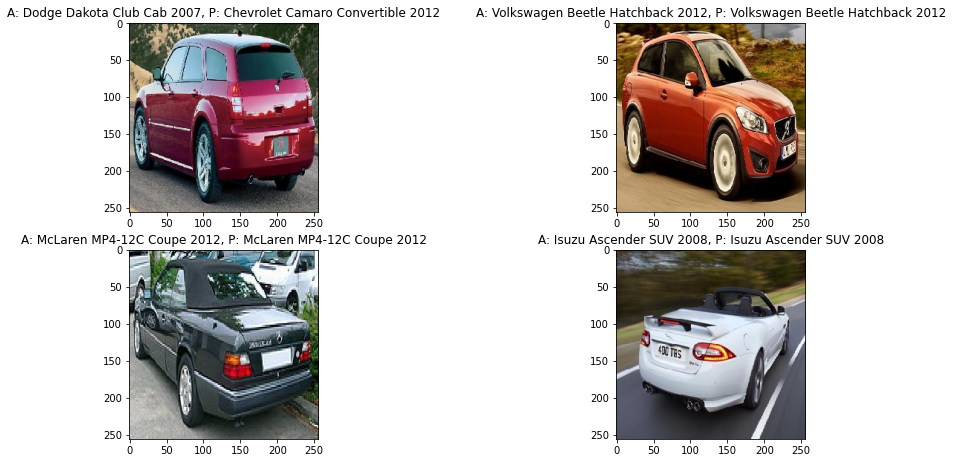

In [ ]:
# Visualize images
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))
#Plots our figures
batch = test_iter.next() #returns an array whose first index is your batch of 32 images
y_hat = np.argmax(model.predict(batch[0]), axis=-1)
for i in range(1,5):
   plt.subplot(4, 2, i)
   plt.imshow((batch[0][i]).astype(int)) #convert float values to int as imshow only works with int values
   #plt.title(f"Class {np.argmax(batch[1][i])-1}, {y_hat[i] -1}")
   plt.title(f"A: {_NAMES[np.argmax(batch[1][i])-1]}, P: {_NAMES[y_hat[i] -1]}")
plt.show()